In [41]:
"""
Import the relevant libraries here
"""

import numpy as np 
import pandas as pd 
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
import random
from imblearn.over_sampling import RandomOverSampler


%matplotlib inline

In [42]:
"""
Here we write a function to import the data
"""

def get_dataset(size = "large"):
    if size == "large":
        url = 'https://raw.githubusercontent.com/SarahTaaherBonna/CS3244Project/master/ExtractedFeaturesDataset/extracted_features_LARGE_v4.csv?token=AIL356YJT3QGXUUCD6GD2Q253IX2K' 
        df = pd.read_csv(url)
        return df
    else:
        url = "https://raw.githubusercontent.com/SarahTaaherBonna/CS3244Project/master/ExtractedFeaturesDataset/extracted_features_SMALL_v6.csv?token=AIL356ZI42NVMF2AOEVW5GS53IYPG"
        df = pd.read_csv(url)
        return df

In [43]:
# test_df = get_dataset()
# test_df.columns

In [44]:
lst1 = ["proportion_exclamations_title",'proportion_exclamations_content', 'proportion_question_title', 'proportion_question_content', 'proportion_allcaps_title'
        ,'proportion_allcaps_content', 'proportion_contractions_title', 'proportion_contractions_content', 'proportion_words_in_title_in_content', 'sentiment_title'
        ,"starts_with_number_title", "len_longest_word_content", "starts_with_5W1H_content", "starts_with_5W1H_title"
        ,"proportion_number_proper_nouns_in_content", "proportion_of_stop_words_in_title"]

# sampling_method = "oversample"
# sampling_method = "undersample"
sampling_method = None

def get_train_and_test(df_size = "large", sampling_method = None, percentage = 0.2):
    def generate_balanced_dataset_undersampling(df): #nested helper function to generate balanced datasets
        only_nonclickbait = df.loc[df['label'] == 0]
        only_clickbait = df.loc[df['label'] == 1]

        while len(only_nonclickbait)!= len(only_clickbait):
            to_drop = random.randint(0, len(only_nonclickbait) - 1)
            only_nonclickbait = only_nonclickbait.drop(only_nonclickbait.index[to_drop])

        frames = [only_clickbait, only_nonclickbait]
        final_balanced_dataset = pd.concat(frames)
        print("Done generating balanced dataset via undersampling")
        return final_balanced_dataset

    df = get_dataset(size = df_size) 
    
    if sampling_method == "oversample":
        X = df[lst1]
        y = df['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state = 51)
#         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = percentage, random_state = 51)
        ros = RandomOverSampler(random_state=0)
#         X_train_resized = X_train.reshape(-1,1)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        X_train = pd.DataFrame(X_train)
        X_train.columns = lst1
        return X_train, X_test, y_train, y_test
    elif sampling_method == "undersample":
        df_balanced = generate_balanced_dataset_undersampling(df)
        df_balanced = df_balanced.sample(frac=1)
        X = df_balanced[lst1]
        y = df_balanced['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state=51)
        return X_train, X_test, y_train, y_test
    else:
        print("Neither undersampling nor oversampling specified")
        X = df[lst1]
        y = df['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state=51)
        return X_train, X_test, y_train, y_test

if sampling_method == "oversample":
    X_train, X_test, y_train, y_test = get_train_and_test(df_size = "large", sampling_method = sampling_method)
    pass
elif sampling_method == "undersample":
    X_train, X_test, y_train, y_test = get_train_and_test(df_size = "large", sampling_method = "undersample")
else:
    X_train, X_test, y_train, y_test = get_train_and_test(df_size = "large", sampling_method = "None")
    pass

print("No. of training examples:", len(X_train))
print("No. of testing examples:", len(X_test))

Neither undersampling nor oversampling specified
No. of training examples: 15630
No. of testing examples: 3908


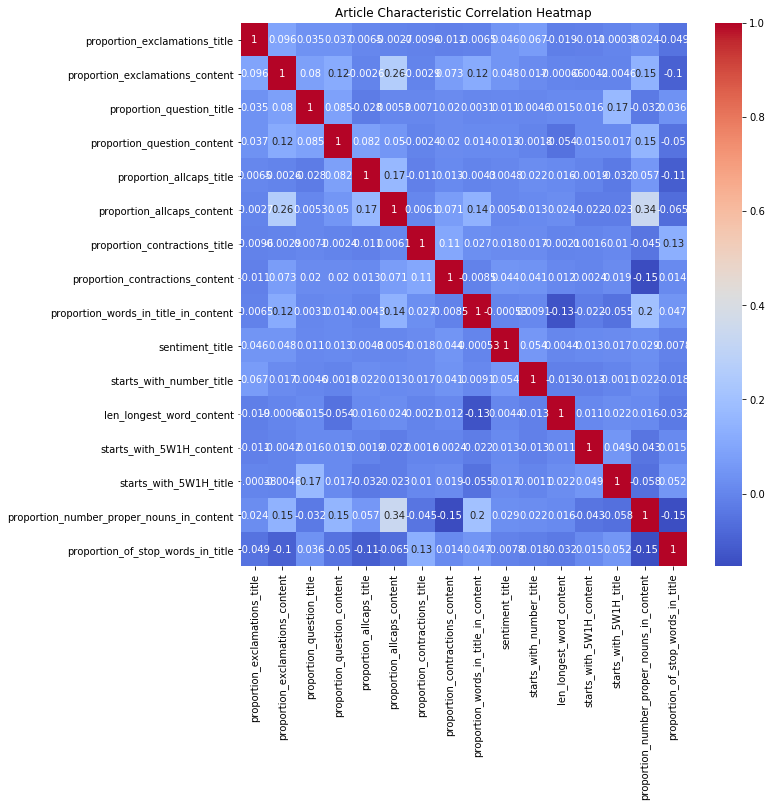

figure saved


In [45]:
"""
Since Naive Bayes assumes that all the input features are conditionally independent, we find the correlation between the input features
"""
def plot_corr_heatmap(fig_name = None):
    plt.subplots(figsize=(10,10))
    ax = plt.axes()
    ax.set_title("Article Characteristic Correlation Heatmap")
    # Generating a correlation heatmap
    corr = X_train.corr()
    sns_plot = sn.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                annot=True, 
               cmap="coolwarm")
    fig = sns_plot.get_figure()
    plt.show()

    if fig_name:
        fig.savefig(fig_name)
        print("figure saved")

if sampling_method == "undersample":
    plot_corr_heatmap("Article Characteristic Correlation Heatmap (undersampling).png")
elif sampling_method == "oversample":
    plot_corr_heatmap("Article Characteristic Correlation Heatmap (oversampling).png")
else:
    plot_corr_heatmap("Article Characteristic Correlation Heatmap imbalanced dataset.png")

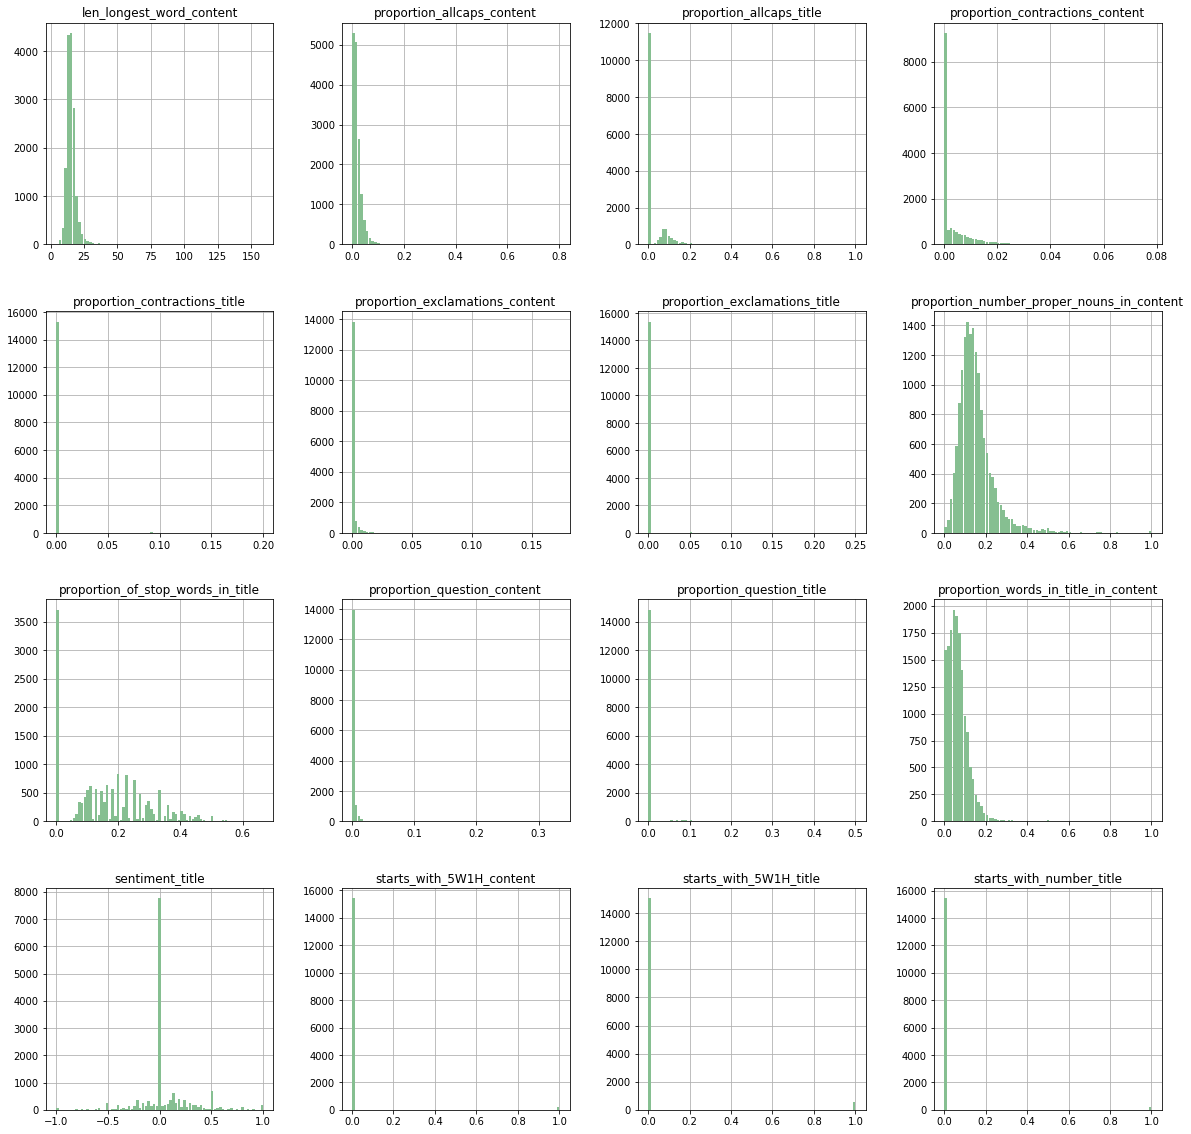

In [46]:
"""
Finding if the features follow some sort of bell-curve shape, to justify the use of Gaussian Naive Bayes
"""
def plot_figure_distribution(fname = None):
    X_train.hist(column = lst1, bins = 75, figsize=(20,20), color='#86bf91', zorder=2, rwidth=0.9);
    
    if fname:
        plt.savefig(fname)
        
    plt.show()

if sampling_method == "undersample":
    plot_figure_distribution("Individual feature distribution (undersampling)")
elif sampling_method == "oversample":
    plot_figure_distribution("Individual feature distribution (oversampling)" )
else:
    plot_figure_distribution("Individual feature distribution imbalanced dataset.png")

In [47]:
"""
Evaluating the model
"""

model = GaussianNB()
y_train_pred = model.fit(X_train, y_train).predict(X_train)
y_test_pred = model.fit(X_train, y_train).predict(X_test)
print("Training performance")
print("Number of mislabelled points out of a total %d points : %d"
       % (y_train.shape[0],(y_train != y_train_pred).sum()))
print("\n")
print("Test performance")
print("Number of mislabelled points out of a total %d points : %d"
       % (y_test.shape[0],(y_test != y_test_pred).sum()))

cm_test = confusion_matrix(y_test, y_test_pred)

Training performance
Number of mislabelled points out of a total 15630 points : 4290


Test performance
Number of mislabelled points out of a total 3908 points : 1001


The F1 score is: 0.3504218040233615


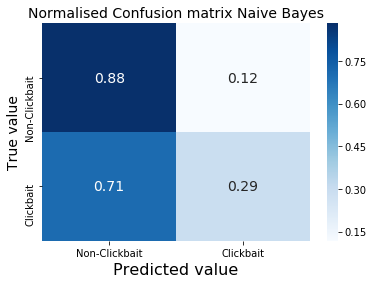

figure saved


In [48]:
def plot_cm_n_calculate_F1_score(confusion_matrix, normalise = True, fig_name = None, method_name = ""):

    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("The F1 score is:", F1_score)
    
    cm = [[0,0],[0,0]]
    if normalise:
        cm[0][0] = TN / (TN + FP)
        cm[0][1] = FP / (TN + FP)
        cm[1][0] = FN / (FN + TP)
        cm[1][1] = TP / (FN + TP)
        plt.title('Normalised Confusion matrix ' + method_name, fontsize = 14)
    else:
        cm[0][0] = TN
        cm[0][1] = FP
        cm[1][0] = FN
        cm[1][1] = TP
        plt.title('Confusion matrix ' + method_name , fontsize = 14)
        
    labels = ['Non-Clickbait', 'Clickbait']
    df_cm = pd.DataFrame(cm, index = labels, columns = labels,)
    sns_plot = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, annot_kws={"size": 14})
    fig = sns_plot.get_figure()
    plt.xlabel('Predicted value', fontsize = 16)
    plt.ylabel('True value', fontsize = 14)
    plt.show()
    
    if fig_name:
        fig.savefig(fig_name)
        print("figure saved")
        
if sampling_method == "undersample":
    plot_cm_n_calculate_F1_score(cm_test, fig_name = "Naive bayes normalised confusion matrix (undersampling).png", method_name = "Naive Bayes")
elif sampling_method == "oversample":
    plot_cm_n_calculate_F1_score(cm_test, fig_name = "Naive bayes normalised confusion matrix (oversampling).png", method_name = "Naive Bayes")
else:
    plot_cm_n_calculate_F1_score(cm_test, fig_name = "Naive bayes normalised confusion matrix (imbalanced).png", method_name = "Naive Bayes")